In [39]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import argparse
import pickle
import os
from tensorflow.keras import models
from tensorflow.keras import layers
import cv2
import matplotlib.pyplot as plt

### Model 

In [3]:
baseModel = VGG16(weights = 'imagenet' , include_top = False ,input_shape = (150,150,3))
baseModel.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [4]:
model = models.Sequential()
model.add(baseModel) 
model.add(layers.Flatten()) 
model.add(layers.Dense(1024 , activation='relu'))
model.add(layers.Dense(512 ,activation ='relu'))
model.add(layers.Dense(3,activation='softmax'))

In [5]:
print('Trainable weights before freezing the conv base:', len(model.trainable_weights))

baseModel.trainable = False

print('Trainable weights After freezing the conv base:', len(model.trainable_weights))

Trainable weights before freezing the conv base: 32
Trainable weights After freezing the conv base: 6


### Dataset Loading & Data Augmentation 

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


train_generator = ImageDataGenerator() 

train_data = train_generator.flow_from_directory('../Dataset/Train/', 
                                                 target_size=(150,150),
                                                 color_mode='rgb',
                                                 batch_size=32,
                                                 class_mode='categorical',
                                                 shuffle=True)


val_generator = ImageDataGenerator() 

val_data = train_generator.flow_from_directory('../Dataset/Validation/', 
                                                 target_size=(150,150),
                                                 color_mode='rgb',
                                                 batch_size=32,
                                                 class_mode='categorical',
                                                 shuffle=True)


Found 1152 images belonging to 3 classes.
Found 201 images belonging to 3 classes.


### Model Training

In [7]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

step_size = train_data.n // train_data.batch_size

H = model.fit_generator(generator=train_data,steps_per_epoch=step_size,epochs=5 , validation_data=val_data, validation_steps=val_data.n // val_data.batch_size,)

/home/tirth/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
36/36 [==============================] - 97s 3s/step - loss: 3.0711 - accuracy: 0.9427 - val_loss: 1.8918 - val_accuracy: 0.9688
Epoch 2/5
36/36 [==============================] - 100s 3s/step - loss: 0.2836 - accuracy: 0.9931 - val_loss: 0.9811 - val_accuracy: 0.9688
Epoch 3/5
36/36 [==============================] - 101s 3s/step - loss: 0.2109 - accuracy: 0.9939 - val_loss: 1.1945 - val_accuracy: 0.9844
Epoch 4/5
36/36 [==============================] - 100s 3s/step - loss: 0.1507 - accuracy: 0.9965 - val_loss: 1.9788 - val_accuracy: 0.9740
Epoch 5/5
36/36 [==============================] - 94s 3s/step - loss: 0.1877 - accuracy: 0.9948 - val_loss: 3.2435 - val_accuracy: 0.9688


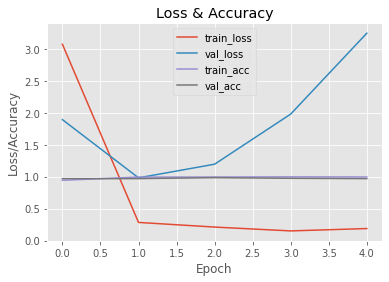

In [40]:
# plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 5), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 5), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 5), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 5), H.history["val_accuracy"], label="val_acc")
plt.title("Loss & Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.legend()

In [8]:
model.save('model.h5', save_format="h5")

### Testing 

In [12]:
test_generator = ImageDataGenerator() 

test_data = train_generator.flow_from_directory('../Dataset/Test/', 
                                                 target_size=(150,150),
                                                 color_mode='rgb',
                                                 batch_size=32,
                                                 class_mode='categorical',
                                                 shuffle=True)

loss , accuracy = model.evaluate(test_data)
accuracy

Found 98 images belonging to 3 classes.
4/4 [==============================] - 6s 1s/step - loss: 6.9344 - accuracy: 0.9592


0.9591836929321289

### Image Prediction

In [26]:
print('Labels')
d = test_data.class_indices

labels_map = {v: k for k, v in d.items()}
labels_map

Labels


{0: 'bird', 1: 'car', 2: 'neg'}

In [41]:
with open('label_mapping', 'wb') as handle:
    pickle.dump(labels_map, handle, protocol=pickle.HIGHEST_PROTOCOL)

Predicted Class : car


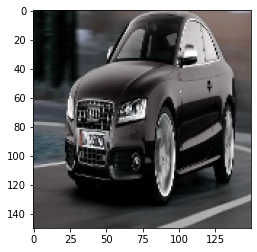

In [32]:
img = cv2.imread('../Dataset/Test/car/331.jpg')
plt.imshow(img)

img = np.reshape(img,[1,150,150,3])
proba = model.predict(img)
op_class = labels_map[np.argmax(proba, axis=1)[0]]

print('Predicted Class : ' + op_class)


Predicted Class : bird


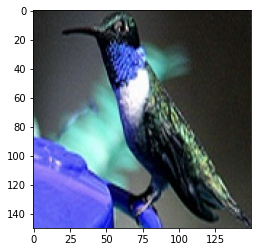

In [33]:
img = cv2.imread('../Dataset/Test/bird/400.jpg')
plt.imshow(img)

img = np.reshape(img,[1,150,150,3])
proba = model.predict(img)
op_class = labels_map[np.argmax(proba, axis=1)[0]]

print('Predicted Class : ' + op_class)


Predicted Class : neg


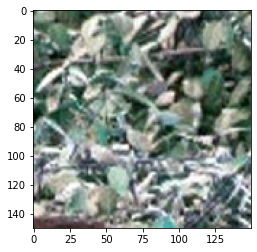

In [34]:
img = cv2.imread('../Dataset/Test/neg/946.jpg')
plt.imshow(img)

img = np.reshape(img,[1,150,150,3])
proba = model.predict(img)
op_class = labels_map[np.argmax(proba, axis=1)[0]]

print('Predicted Class : ' + op_class)

In [42]:
l = [2,3,1,4]

np.argsort(l)

array([2, 0, 1, 3])